## Zillow Regression with Clustering Project

### Project Goals

- The goal of this project is to find features or clusters of features to improve Zillow's log error for single family residences in three Southern California counties and to use these features to develop an improved machine learning model.

- My initial hypothesis is that the size of the home in square feet, the age of the home, and the location are the main features affecting log error.

- Initial questions:
    - What is the relationship between square feet and log error? Do area clusters have a large impact on the overall log error?
    - Does the size of the home affect log error? Can that error be better determined by clustering by size?
    - Does the location have an effect on log error? Where does the most log error occur?

### Project Planning

- Acquire the dataset from the Codeup database using SQL
- Prepare the data with the intent to improve the log error from Zestimates; clean the data and encode categorical features if necessary; ensure that the data is tidy
- Split the data into train, validate, and test datasets using a 60/20/20 split
- Explore the data:
    - Univariate, bivariate, and multivariate analyses; statistical tests for significance, find the three primary features or clusters affecting log error
    - Create graphical representations of the analyses
    - Answer questions about the data
    - Document findings
- Train and test at least three models:
    - Establish a baseline
    - Select key features and train multiple linear regression models
    - Test the model on the validate set, adjust for overfitting if necessary
- Select the best model for the project goals:
    - Determine which model performs best on the validate set
- Test and evaluate the model:
    - Use the model on the test set and evaluate its performance (RMSE, R2, etc.)
    - Visualize the data using an array of probabilities on the test set
- Document key findings and takeaways, answer the questions
    
### Executive Summary

- After running four models on my train and validate sets, I decided to use the polynomial linear regression model because it provided the lowest RMSE compared to baseline.

- I selected the features for modeling based on statistical analysis (square feet of the home, ratio of bedrooms and bathrooms, lot size, age, number of bathrooms, area cluster, and size cluster). I selected a degree multiplier of 2. The RMSE of the selected model was .162 on train, .152 on validate, and .?? on test.

- Takeaways: the selected features improved the overall log error.

### Acquire and Prepare Data

In [1]:
import pandas as pd
import numpy as np
import wrangle
import model
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import env
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression 
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

In [2]:
def spearman_test(x,y):
    '''This function takes in two arguments and performs a Spearman's statistical test. It prints whether or not
    we can reject the null hypothesis and returns the coefficient and p-value for the test.'''
    # run the stat test using the two arguments and assign results to variables
    corr, p = stats.spearmanr(x,y)
    # set alpha to .05
    alpha = .05
    # conditional clause that prints whether to accept or reject the null hypothesis
    if p < alpha:
        print('We reject the null hypothesis.')
    else:
        print('We fail to reject the null hypothesis.')
    # output the Spearman coefficient and p-value
    return corr, p

In [3]:
df = wrangle.wrangle_zillow2()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   logerror                      52442 non-null  float64
 2   bathroomcnt                   52442 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   fips                          52442 non-null  float64
 6   latitude                      52442 non-null  float64
 7   longitude                     52442 non-null  float64
 8   lotsizesquarefeet             52073 non-null  float64
 9   regionidcity                  51405 non-null  float64
 10  regionidcounty                52442 non-null  float64
 11  regionidzip                   52416 non-null  float64
 12  yearbuilt                     52326 non-null  float64
 13  s

In [5]:
df = wrangle.handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75)

In [6]:
df = df.dropna()

In [7]:
df = wrangle.get_counties(df)

In [8]:
wrangle.verify_counties(df)

LA County Verified:  True
Orange County Verified:  True
Ventura County Verified:  True


In [9]:
df = wrangle.create_features(df)

In [10]:
df = wrangle.remove_outliers(df)

In [11]:
train, X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.split(df, target_var='logerror')

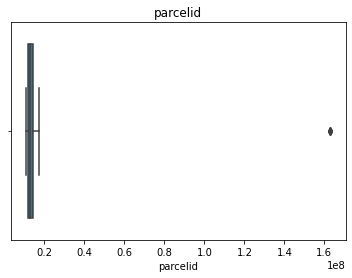

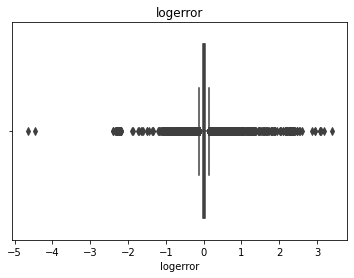

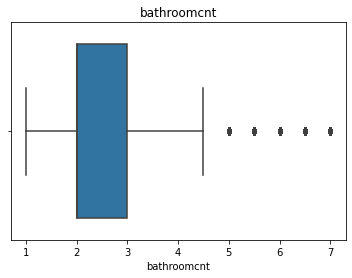

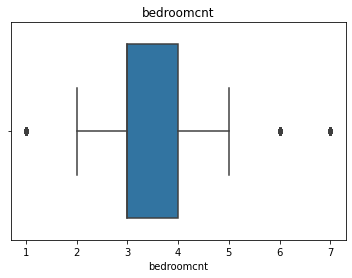

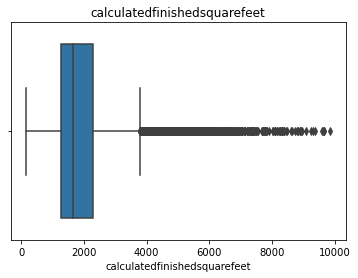

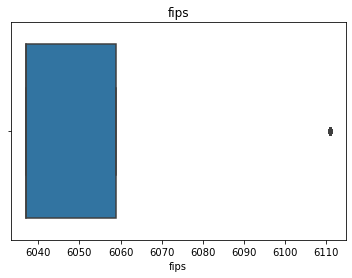

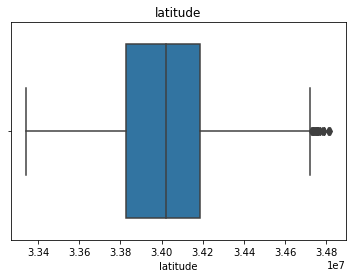

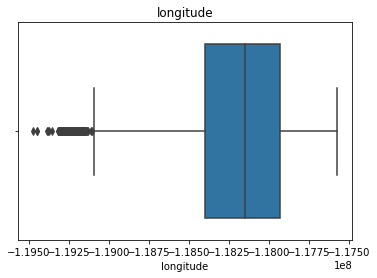

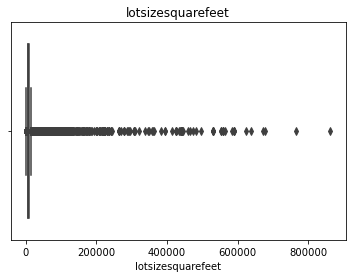

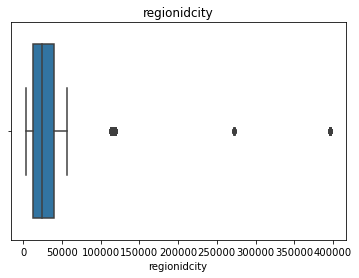

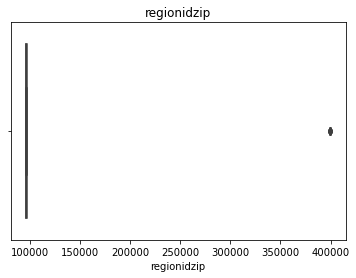

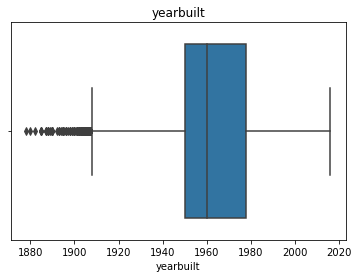

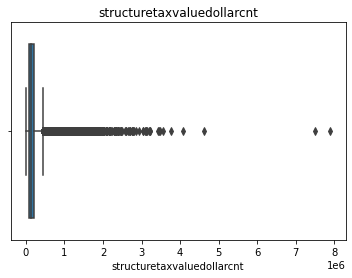

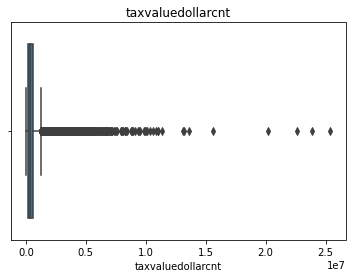

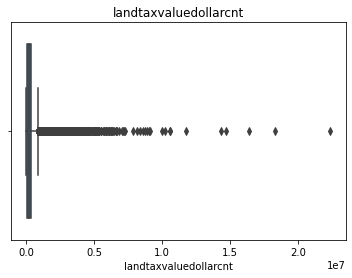

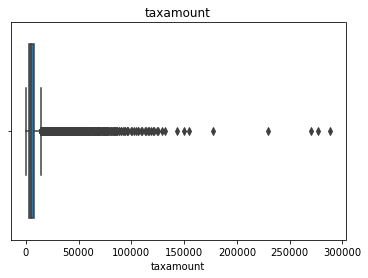

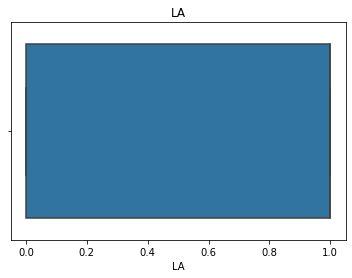

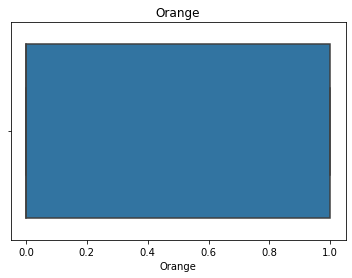

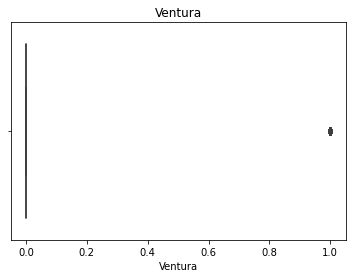

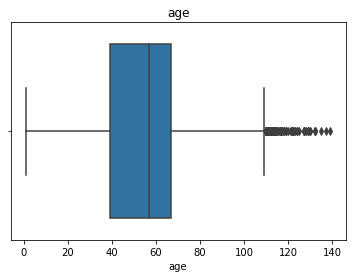

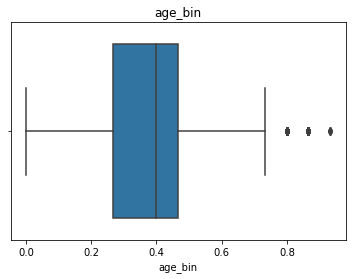

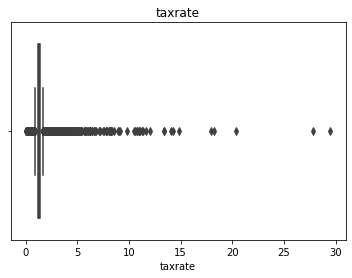

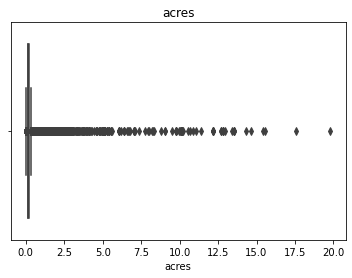

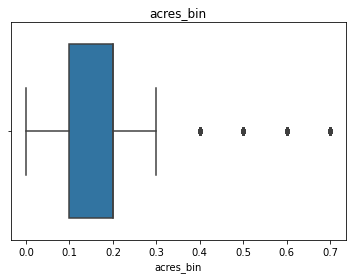

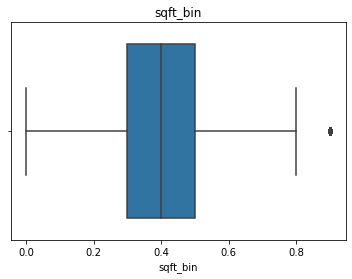

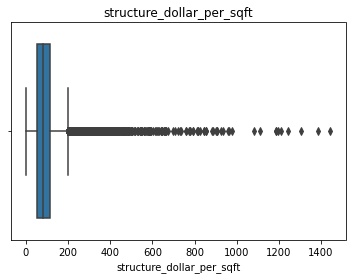

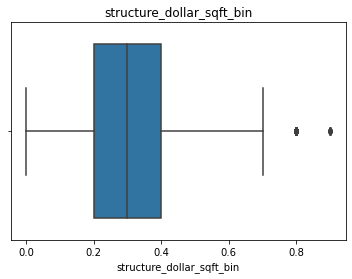

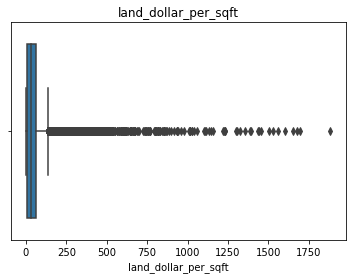

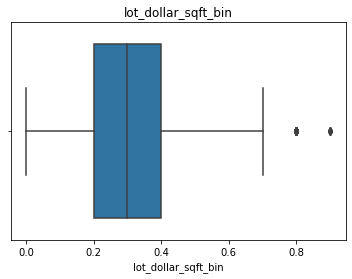

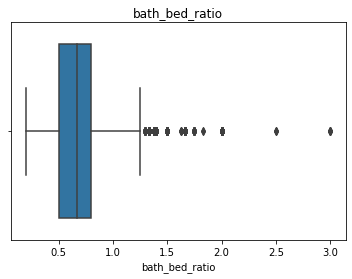

In [12]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50710 entries, 0 to 52441
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50710 non-null  int64  
 1   logerror                      50710 non-null  float64
 2   bathroomcnt                   50710 non-null  float64
 3   bedroomcnt                    50710 non-null  float64
 4   calculatedfinishedsquarefeet  50710 non-null  float64
 5   fips                          50710 non-null  float64
 6   latitude                      50710 non-null  float64
 7   longitude                     50710 non-null  float64
 8   lotsizesquarefeet             50710 non-null  float64
 9   regionidcity                  50710 non-null  float64
 10  regionidzip                   50710 non-null  float64
 11  yearbuilt                     50710 non-null  float64
 12  structuretaxvaluedollarcnt    50710 non-null  float64
 13  t

### Acquisition and Preparation Takeaways

- The dataset was acquired from the Codeup database using a SQL query.

- Data was limited to homes with a transaction in 2017, homes with more than 0 and less than 8 bedrooms, more than 0 and less than 8 bathrooms, home size less than 10,000 square feet, homes with less than 20 acres, and homes with a tax rate less than 30. All observations with null values were removed. 

- FIPS was encoded and new features (age, age_bin, taxrate, acres, acres_bin, sqft_bin, structure_dollar_per_sqft, structure_dollar_per_sqft_bin, land_dollar_per_sqft, lot_dollar_sqft_bin) were created.

- The cleaned dataset has 50699 observations and 29 columns. All columns are integers or floats.

- The dataset has been split into train, validate, and test sets using a 60/20/20 split.

## Exploration

In [14]:
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

In [15]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    19699
(0.05, 0.2]       4929
(-0.2, -0.05]     3676
(0.2, 4.0]        1404
(-5.0, -0.2]       718
Name: logerror_bins, dtype: int64

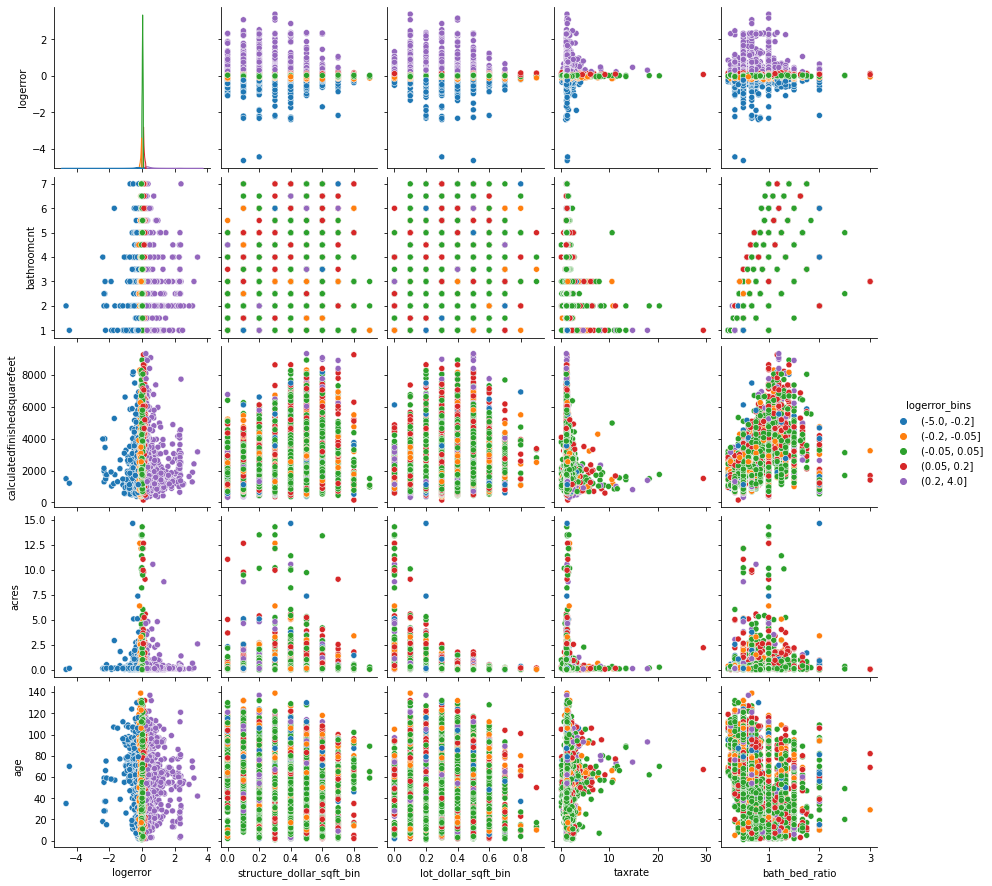

In [16]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])

In [17]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'taxrate', 'calculatedfinishedsquarefeet', 'age']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# fit the minmaxscaler to X_train
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

In [18]:
X_train = scale_and_concat(X_train)
X_validate = scale_and_concat(X_validate)
X_test = scale_and_concat(X_test)

In [19]:
X_train.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,...,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,scaled_latitude,scaled_longitude,scaled_bathroomcnt,scaled_taxrate,scaled_calculatedfinishedsquarefeet,scaled_age
count,3.042600e+04,30426.000000,30426.000000,30426.000000,30426.000000,3.042600e+04,3.042600e+04,30426.000000,30426.000000,30426.000000,...,30426.000000,30426.000000,30426.000000,30426.000000,30426.000000,30426.000000,30426.000000,30426.000000,30426.000000,30426.000000
mean,1.296643e+07,2.280730,3.296786,1896.727799,6049.254125,3.402006e+07,-1.181912e+08,9610.639289,33461.303490,96639.862026,...,0.276836,47.991934,0.289174,0.695892,0.459574,0.674797,0.213455,0.044863,0.190493,0.384124
std,2.122549e+06,0.971769,0.910597,928.340853,21.106480,2.728027e+05,3.559632e+05,18443.061349,49303.896323,4616.472075,...,0.146289,71.120122,0.128741,0.234544,0.184586,0.187061,0.161962,0.016292,0.101358,0.165282
min,1.071186e+07,1.000000,1.000000,152.000000,6037.000000,3.334085e+07,-1.194753e+08,480.000000,3491.000000,95982.000000,...,0.000000,0.032487,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.153249e+07,2.000000,3.000000,1264.000000,6037.000000,3.382691e+07,-1.183935e+08,5590.250000,12447.000000,96206.000000,...,0.200000,9.173378,0.200000,0.500000,0.328880,0.568455,0.166667,0.039142,0.121411,0.275362
50%,1.260411e+07,2.000000,3.000000,1650.000000,6037.000000,3.401992e+07,-1.181491e+08,6815.000000,24812.000000,96420.000000,...,0.300000,30.157623,0.300000,0.666667,0.459478,0.696891,0.166667,0.041486,0.163555,0.405797
75%,1.413675e+07,3.000000,4.000000,2277.000000,6059.000000,3.418471e+07,-1.179263e+08,8700.000000,40227.000000,96996.000000,...,0.400000,59.778000,0.400000,0.800000,0.570982,0.814012,0.333333,0.045961,0.232012,0.478261
max,1.629608e+08,7.000000,7.000000,9311.000000,6111.000000,3.481877e+07,-1.175723e+08,638766.000000,396556.000000,399675.000000,...,0.900000,1649.149966,0.900000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)

In [21]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1]))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    return k_comparisons_df

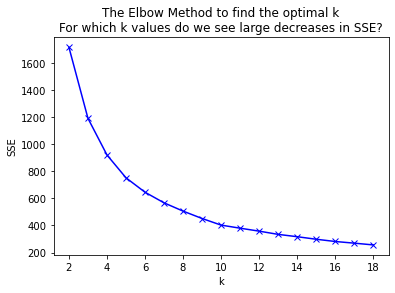

,k,sse
0,2,1713.866295
1,3,1190.082926
2,4,919.780975
3,5,751.432374
4,6,645.160233
5,7,566.910005
6,8,505.944951
7,9,451.420333
8,10,402.695964
9,11,379.944361


In [22]:
find_k(X_train, cluster_vars, k_range)

In [23]:
k = 5

In [24]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 217)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans

In [25]:
kmeans = create_clusters(X_train, k, cluster_vars)

In [26]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

In [27]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

In [28]:
centroid_df

,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin
0,0,0.500838,0.602468,0.541036
1,1,0.610561,0.357461,0.298513
2,2,0.376768,0.769952,0.414156
3,3,0.846357,0.695445,0.234793
4,4,0.219379,0.897693,0.227107


In [29]:
# label cluster for each observation

def assign_clusters(df, kmeans, cluster_vars, cluster_name, centroid_df):
    clusters = pd.DataFrame(kmeans.predict(df[cluster_vars]), 
                            columns=[cluster_name], index=df.index)

    clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

    df = pd.concat([df, clusters_centroids], axis=1)
    return df

In [30]:
X_train = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
X_validate = assign_clusters(X_validate, kmeans, cluster_vars, cluster_name, centroid_df)
X_test = assign_clusters(X_test, kmeans, cluster_vars, cluster_name, centroid_df)

In [31]:
pd.DataFrame(X_train.groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_age_bin'])['area_cluster'].count())

,,,,area_cluster
area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin,
0,0.500838,0.602468,0.541036,8560
1,0.610561,0.357461,0.298513,4566
2,0.376768,0.769952,0.414156,10184
3,0.846357,0.695445,0.234793,2407
4,0.219379,0.897693,0.227107,4709


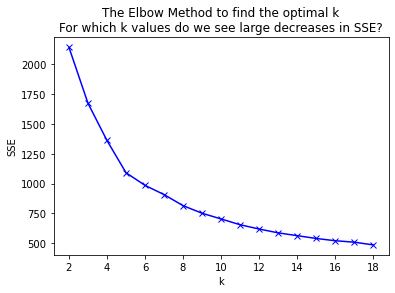

,k,sse
0,2,2142.066558
1,3,1673.836327
2,4,1361.418541
3,5,1091.446914
4,6,985.594979
5,7,908.382597
6,8,815.633162
7,9,752.087653
8,10,704.198285
9,11,655.759338


In [32]:
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']
cluster_name = 'size_cluster'
k_range = range(2,20)

find_k(X_train, cluster_vars, k_range)

In [33]:
k=5
cluster_name = 'size_cluster'
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']

# fit kmeans 
kmeans = create_clusters(X_train, k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X_train = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
X_validate = assign_clusters(X_validate, kmeans, cluster_vars, cluster_name, centroid_df)
X_test = assign_clusters(X_test, kmeans, cluster_vars, cluster_name, centroid_df)

In [34]:
pd.DataFrame(X_train.groupby(['size_cluster', 'centroid_scaled_bathroomcnt', 'centroid_sqft_bin',
                              'centroid_acres_bin', 'centroid_bath_bed_ratio'])['area_cluster'].count())

,,,,,area_cluster
size_cluster,centroid_scaled_bathroomcnt,centroid_sqft_bin,centroid_acres_bin,centroid_bath_bed_ratio,
0,0.330466,0.569872,0.195806,0.718157,6102
1,0.168445,0.348534,0.163479,0.616467,11763
2,0.558261,0.705126,0.265300,1.111959,2538
3,0.012505,0.178708,0.127577,0.429759,5791
4,0.238146,0.361555,0.131805,0.999392,4232


Text(0.5, 0.91, 'Do area clusters reveal differences in age, location, and size?')

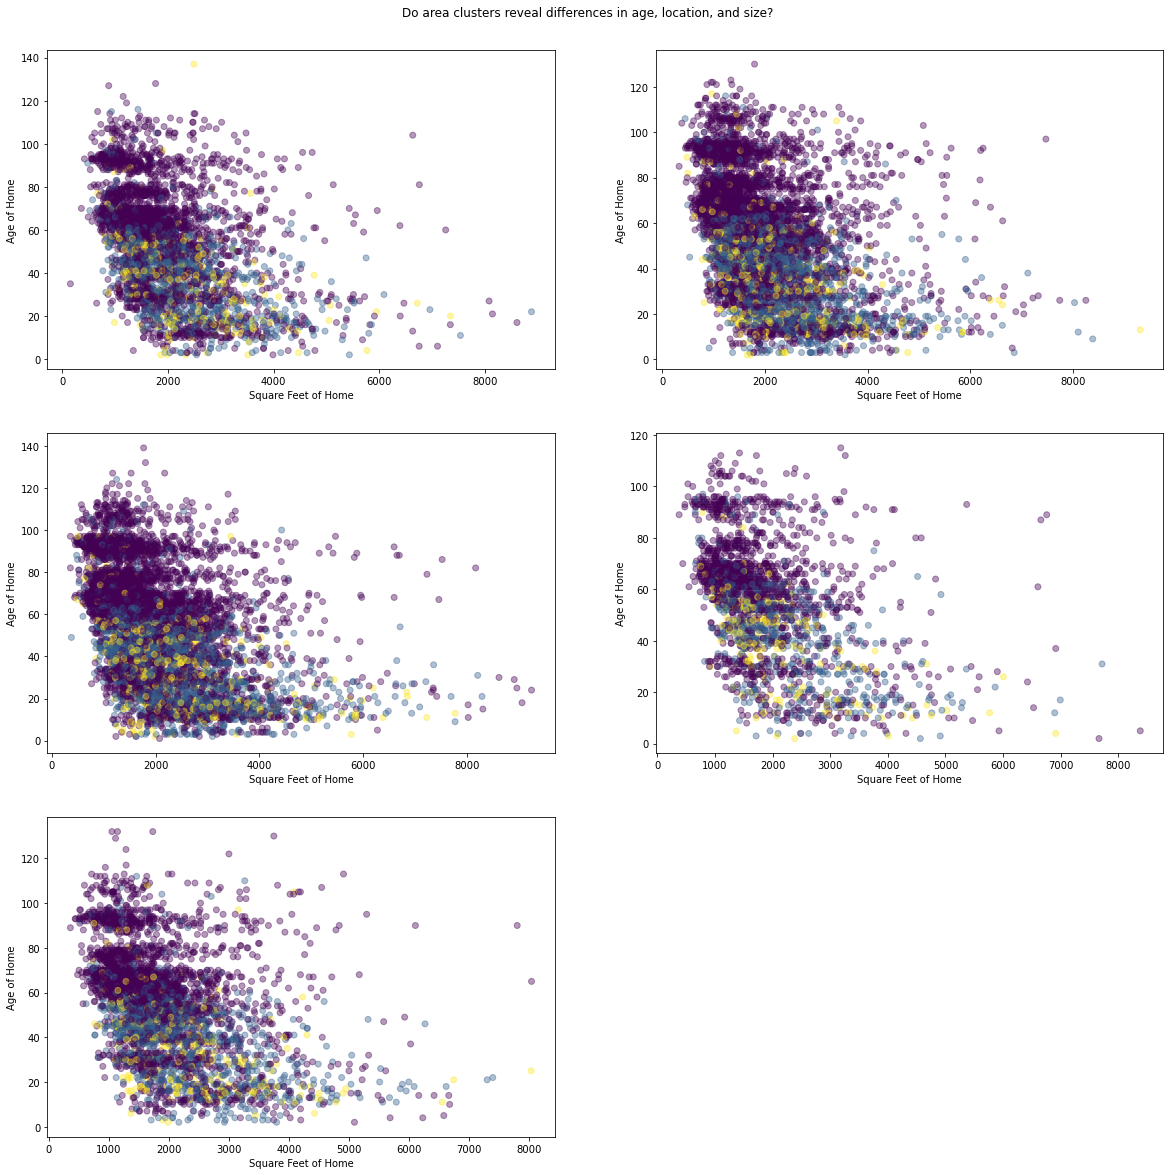

In [35]:
plt.figure(figsize=(20,20))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.subplot(3,2,1)
plt.scatter(y=X_train[X_train.area_cluster==1].age, x=X_train[X_train.area_cluster==1].calculatedfinishedsquarefeet, alpha=.4,
           c=X_train[X_train.area_cluster==1].fips)
plt.ylabel('Age of Home')
plt.xlabel('Square Feet of Home')
plt.title('')
plt.subplot(3,2,2)
plt.scatter(y=X_train[X_train.area_cluster==0].age, x=X_train[X_train.area_cluster==0].calculatedfinishedsquarefeet, alpha=.4, 
           c=X_train[X_train.area_cluster==0].fips)
plt.ylabel('Age of Home')
plt.xlabel('Square Feet of Home')
plt.title('')
plt.subplot(3,2,3)
plt.scatter(y=X_train[X_train.area_cluster==2].age, x=X_train[X_train.area_cluster==2].calculatedfinishedsquarefeet, alpha=.4, 
           c=X_train[X_train.area_cluster==2].fips)
plt.ylabel('Age of Home')
plt.xlabel('Square Feet of Home')
plt.title('')
plt.subplot(3,2,4)
plt.scatter(y=X_train[X_train.area_cluster==3].age, x=X_train[X_train.area_cluster==3].calculatedfinishedsquarefeet, alpha=.4, 
           c=X_train[X_train.area_cluster==3].fips)
plt.ylabel('Age of Home')
plt.xlabel('Square Feet of Home')
plt.title('')
plt.subplot(3,2,5)
plt.scatter(y=X_train[X_train.area_cluster==4].age, x=X_train[X_train.area_cluster==4].calculatedfinishedsquarefeet, alpha=.4, 
           c=X_train[X_train.area_cluster==4].fips)
plt.ylabel('Age of Home')
plt.xlabel('Square Feet of Home')
plt.title('')

plt.suptitle('Do area clusters reveal differences in age, location, and size?', y=.91)

In [36]:
spearman_test(X_train.age, X_train.scaled_calculatedfinishedsquarefeet)

We reject the null hypothesis.


(-0.5208228977300849, 0.0)

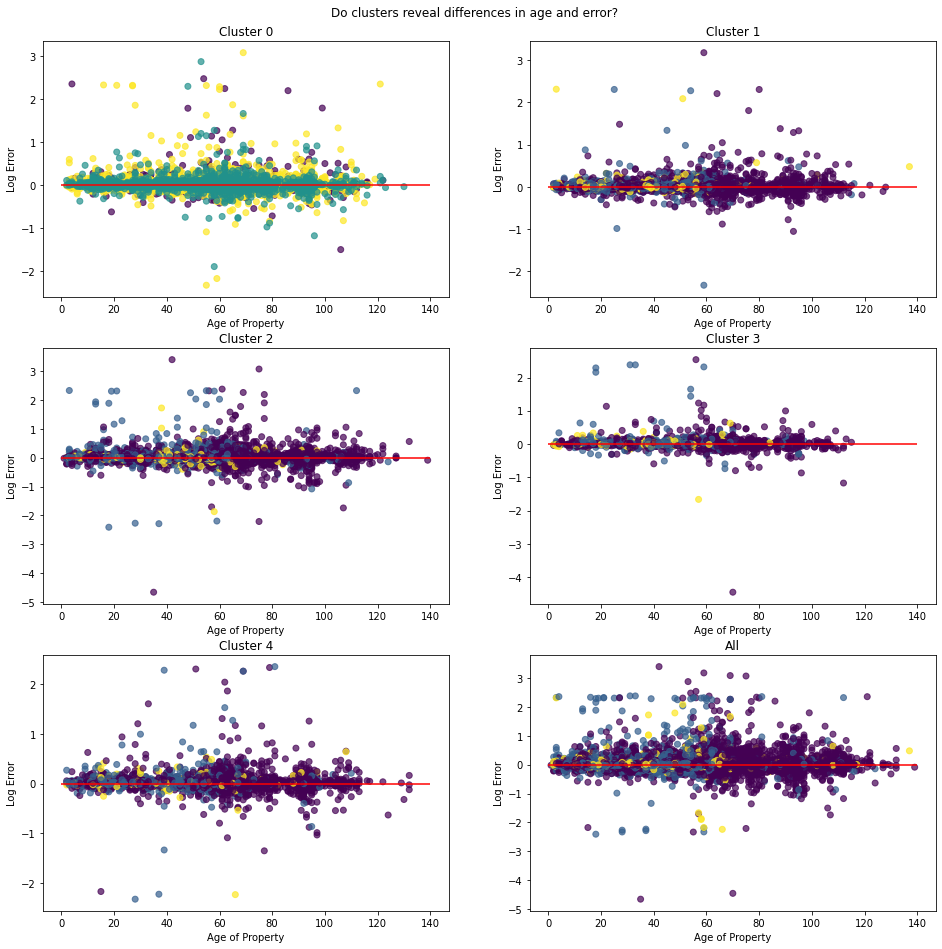

In [37]:
plt.figure(figsize=[16,16])
plt.subplot(3,2,1)
plt.scatter(y=y_train[X_train.area_cluster==0].logerror, x=X_train[X_train.area_cluster==0].age, alpha=.7, 
            c=X_train[X_train.area_cluster==0].size_cluster)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 0')

plt.subplot(3,2,2)
plt.scatter(y=y_train[X_train.area_cluster==1].logerror, x=X_train[X_train.area_cluster==1].age, alpha=.7, 
            c=X_train[X_train.area_cluster==1].fips)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 1')

plt.subplot(3,2,3)
plt.scatter(y=y_train[X_train.area_cluster==2].logerror, x=X_train[X_train.area_cluster==2].age, alpha=.7, 
            c=X_train[X_train.area_cluster==2].fips)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 2')

plt.subplot(3,2,4)
plt.scatter(y=y_train[X_train.area_cluster==3].logerror, x=X_train[X_train.area_cluster==3].age, alpha=.7, 
            c=X_train[X_train.area_cluster==3].fips)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 3')

plt.subplot(3,2,5)
plt.scatter(y=y_train[X_train.area_cluster==4].logerror, x=X_train[X_train.area_cluster==4].age, alpha=.7, 
            c=X_train[X_train.area_cluster==4].fips)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 4')

plt.subplot(3,2,6)
plt.scatter(y=y_train.logerror, x=X_train.age, alpha=.7, 
            c=X_train.fips)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('All')


plt.suptitle("Do clusters reveal differences in age and error?", y=.91)
plt.show()

In [38]:
spearman_test(X_train.age, y_train.logerror)

We reject the null hypothesis.


(-0.04590700950029634, 1.1333866831023384e-15)

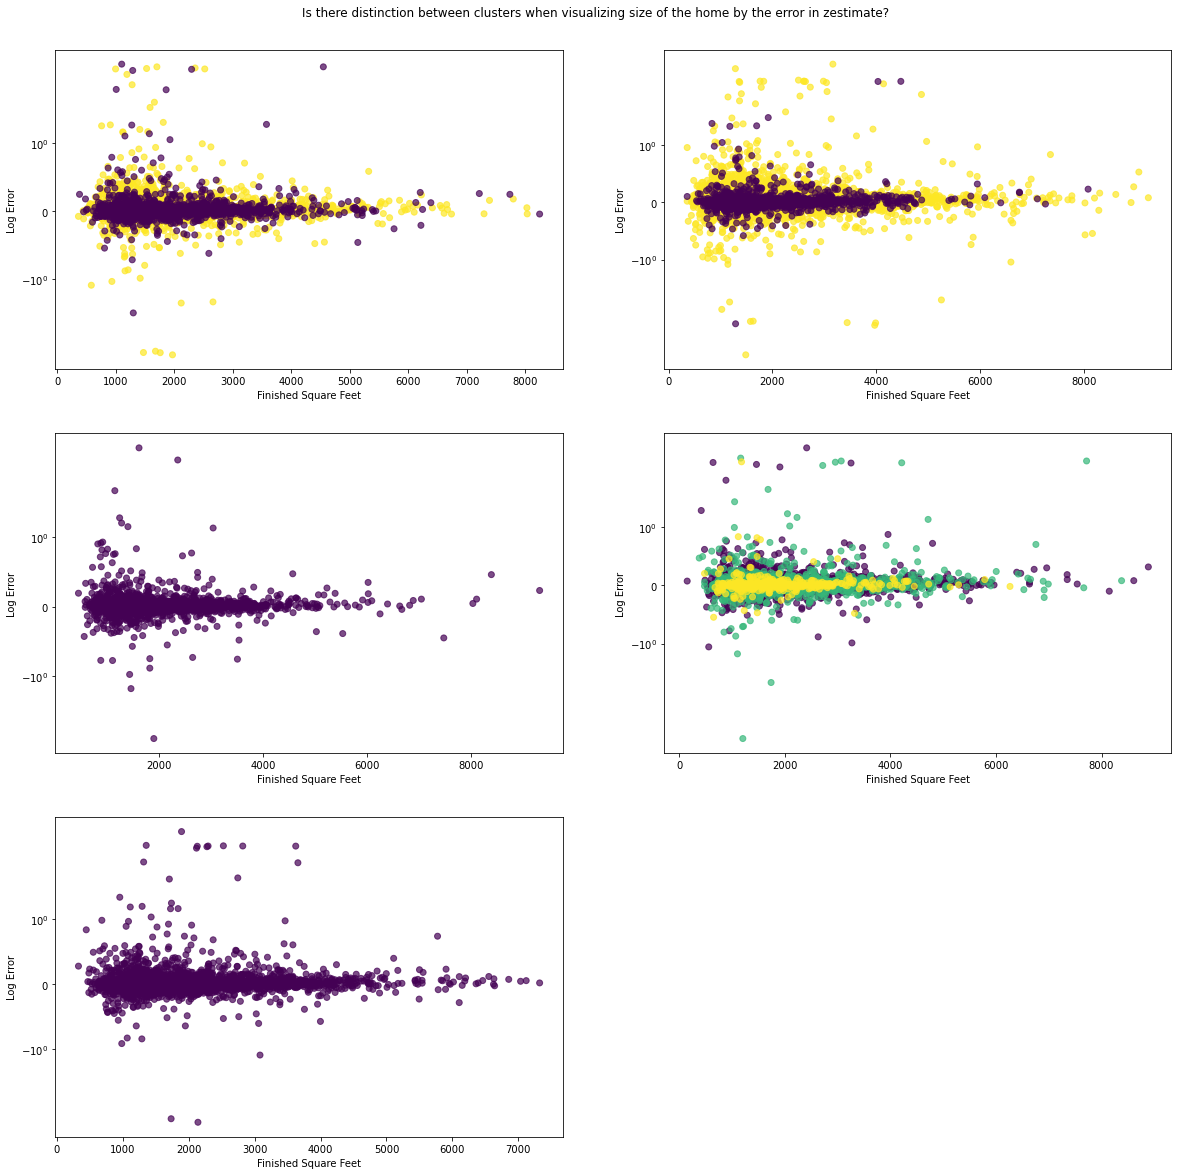

In [39]:
plt.figure(figsize=(20,20))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.subplot(3,2,1)
plt.scatter(y=y_train[X_train.size_cluster==0].logerror, x=X_train[X_train.size_cluster==0].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==0].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,2)
plt.scatter(y=y_train[X_train.size_cluster==1].logerror, x=X_train[X_train.size_cluster==1].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==1].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,3)
plt.scatter(y=y_train[X_train.size_cluster==2].logerror, x=X_train[X_train.size_cluster==2].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==2].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,4)
plt.scatter(y=y_train[X_train.size_cluster==3].logerror, x=X_train[X_train.size_cluster==3].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==3].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,5)
plt.scatter(y=y_train[X_train.size_cluster==4].logerror, x=X_train[X_train.size_cluster==4].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==4].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.suptitle('Is there distinction between clusters when visualizing size of the home by the error in zestimate?', y=.91)
plt.show()

In [40]:
spearman_test(X_train.calculatedfinishedsquarefeet, y_train.logerror)

We reject the null hypothesis.


(0.07248953893045822, 9.78431920255917e-37)

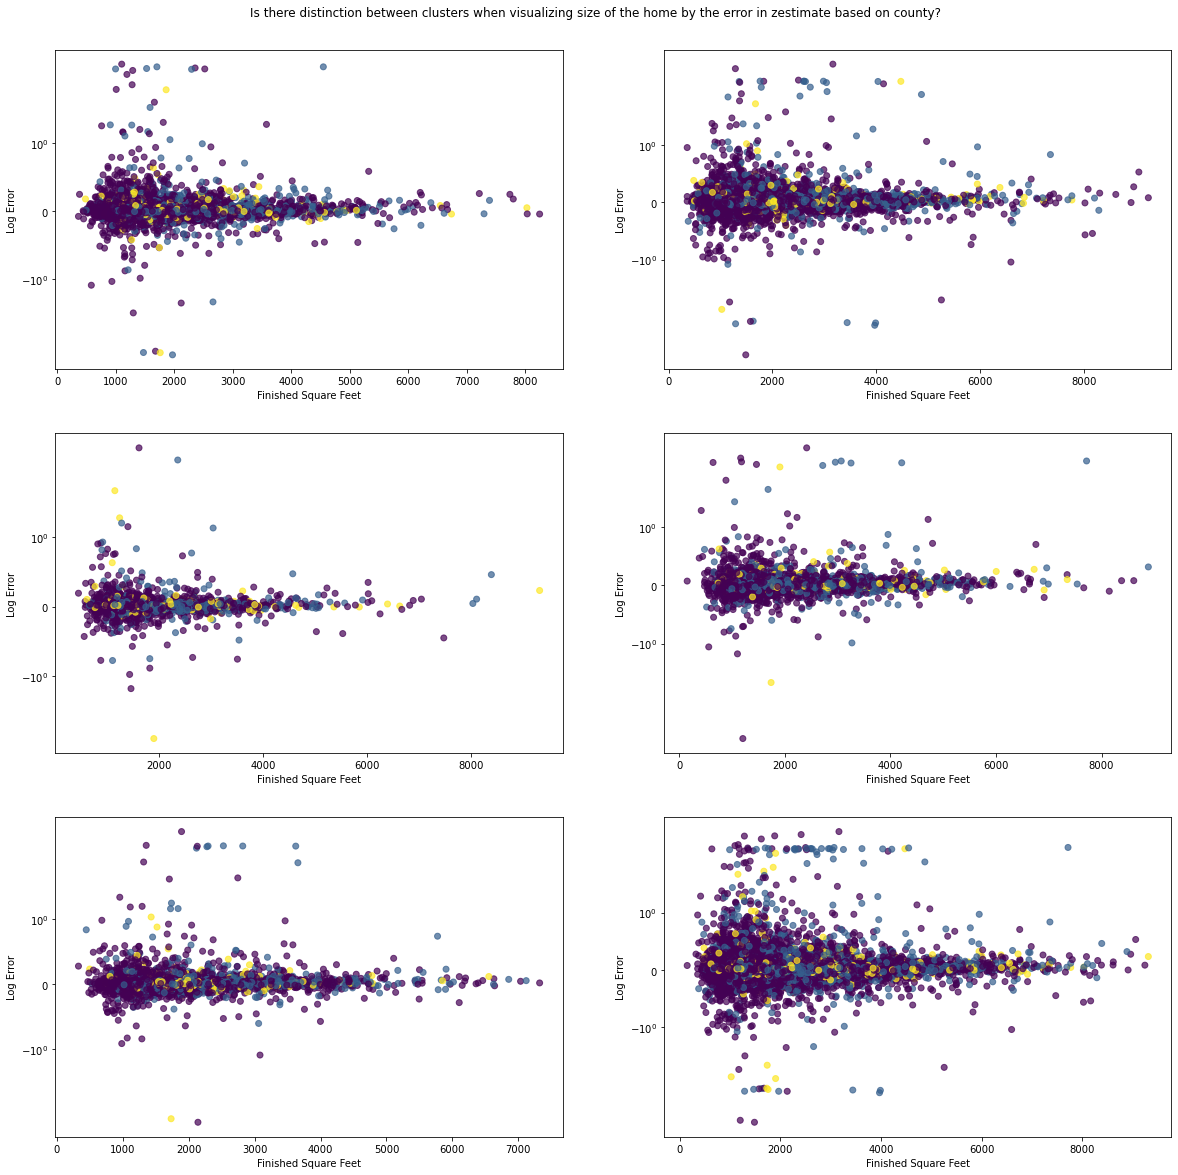

In [41]:
plt.figure(figsize=(20,20))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.subplot(3,2,1)
plt.scatter(y=y_train[X_train.size_cluster==0].logerror, x=X_train[X_train.size_cluster==0].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==0].fips, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,2)
plt.scatter(y=y_train[X_train.size_cluster==1].logerror, x=X_train[X_train.size_cluster==1].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==1].fips, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,3)
plt.scatter(y=y_train[X_train.size_cluster==2].logerror, x=X_train[X_train.size_cluster==2].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==2].fips, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,4)
plt.scatter(y=y_train[X_train.size_cluster==3].logerror, x=X_train[X_train.size_cluster==3].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==3].fips, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,5)
plt.scatter(y=y_train[X_train.size_cluster==4].logerror, x=X_train[X_train.size_cluster==4].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==4].fips, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,6)
plt.scatter(y=y_train.logerror, x=X_train.calculatedfinishedsquarefeet, 
            c=X_train.fips, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.suptitle('Is there distinction between clusters when visualizing size of the home by the error in zestimate based on county?', y=.91)
plt.show()

In [42]:
F, p = stats.f_oneway(X_train['calculatedfinishedsquarefeet'][X_train['fips'] == 6037],
               X_train['calculatedfinishedsquarefeet'][X_train['fips'] == 6059],
               X_train['calculatedfinishedsquarefeet'][X_train['fips'] == 6111])

alpha = .05
if p < .05:
    print('We reject the null hypothesis that there is no difference in square footage of the home between counties.')
else:
    print('We fail to reject the null hypothesis that there is no difference in square footage of the home between counties.')

We reject the null hypothesis that there is no difference in square footage of the home between counties.


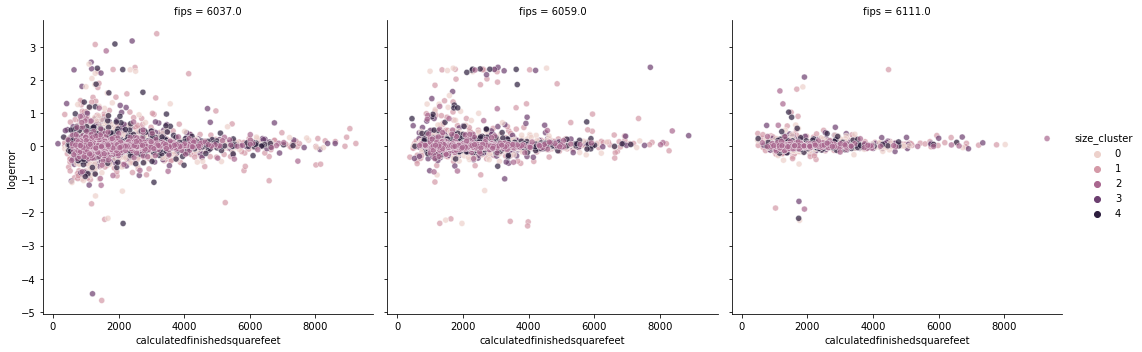

In [43]:
sns.relplot(y=y_train.logerror, x=X_train.calculatedfinishedsquarefeet, hue=X_train.size_cluster, 
            col=X_train.fips, alpha=.7)


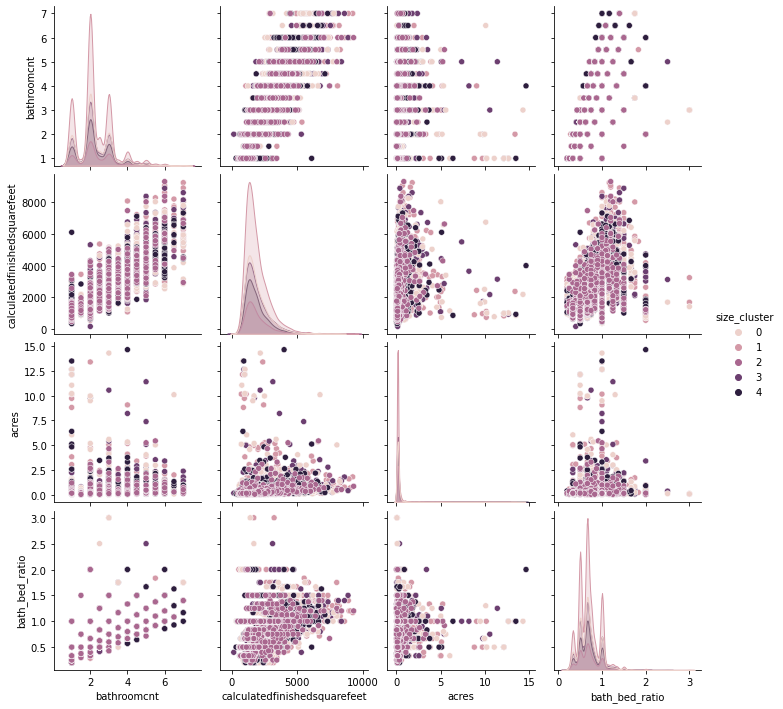

In [44]:
plt_df = X_train[['bathroomcnt', 'calculatedfinishedsquarefeet', 
                    'acres', 'bath_bed_ratio', 'size_cluster']]

sns.pairplot(data=plt_df, hue='size_cluster')

## Modeling

- Select features for modeling

In [45]:
train_df = X_train[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age',
                        'size_cluster', 'area_cluster']]
validate_df = X_validate[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age', 
                        'size_cluster', 'area_cluster']]
test_df = X_test[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age',
                        'size_cluster', 'area_cluster']]

#### OLS Model

In [46]:
ols_model = LinearRegression().fit(train_df, y_train.logerror)

In [47]:
train_df['yhat'] = ols_model.predict(train_df)
validate_df['yhat'] = ols_model.predict(validate_df)

In [48]:
baseline = y_train.logerror.mean()

In [49]:
baseline

0.01839405985257394

In [50]:
train_df['baseline'] = baseline

In [51]:
validate_df['baseline'] = baseline

In [52]:
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(y_train.logerror, train_df.yhat))
RMSE

0.1774348632023078

In [53]:
RMSE_baseline = sqrt(mean_squared_error(y_train.logerror, train_df.baseline))
RMSE_baseline

0.17757623752334567

#### Lasso Lars Model

In [54]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(train_df, y_train.logerror)

# predict train
train_df['yhat'] = lars.predict(train_df)
validate_df['yhat'] = lars.predict(validate_df)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, train_df.yhat)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, validate_df.yhat)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train,
     "Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17757623752334567 Out-of-Sample:  0.16765897542653777


In [55]:
m1 = model.lasso_lars_model(train_df, validate_df, y_train, y_validate, 1.0)
m2 = model.glm_model(train_df, validate_df, y_train, y_validate, 0, 1)
m3 = model.poly_lm(train_df, validate_df, y_train, y_validate, 2)
m4 = model.lrm(train_df, validate_df, y_train, y_validate)

In [56]:
model.model_performance(m1,m2,m3,m4)

,Model,Train RMSE,Validate RMSE,r2 score,Better than Baseline,RMSE Difference
0,Lasso Lars,0.1776,0.1677,0.0000,False,0.0000
1,Tweedie Regressor,0.1776,0.1677,0.0002,True,0.0000
2,Poly Linear Regression,0.1773,0.1678,0.0030,True,0.0003
3,OLS,0.1774,0.1677,0.0016,True,0.0001


In [57]:
m1 = model.lasso_lars_model(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 1.0)
m2 = model.glm_model(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 2, 1)
m3 = model.poly_lm(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 2)
m4 = model.lrm(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate))

In [58]:
model.model_performance(m1,m2,m3,m4)

,Model,Train RMSE,Validate RMSE,r2 score,Better than Baseline,RMSE Difference
0,Lasso Lars,0.1632,0.1530,0.0000,True,0.0087
1,Tweedie Regressor,0.1632,0.1530,0.0005,True,0.0087
2,Poly Linear Regression,0.1619,0.1518,0.0159,True,0.0100
3,OLS,0.1622,0.1519,0.0131,True,0.0097


In [59]:
pf = PolynomialFeatures(degree=2)
pf.fit(train_df)
pf.transform(validate_df)

array([[1.00000000e+00, 5.03548422e-01, 7.50000000e-01, ...,
        3.38341438e-04, 3.38341438e-04, 3.38341438e-04],
       [1.00000000e+00, 1.80478218e-01, 1.66666667e-01, ...,
        3.38341438e-04, 3.38341438e-04, 3.38341438e-04],
       [1.00000000e+00, 9.77180915e-02, 0.00000000e+00, ...,
        3.38341438e-04, 3.38341438e-04, 3.38341438e-04],
       ...,
       [1.00000000e+00, 1.56676493e-01, 1.66666667e-01, ...,
        3.38341438e-04, 3.38341438e-04, 3.38341438e-04],
       [1.00000000e+00, 3.50474943e-01, 3.33333333e-01, ...,
        3.38341438e-04, 3.38341438e-04, 3.38341438e-04],
       [1.00000000e+00, 1.55803035e-01, 1.66666667e-01, ...,
        3.38341438e-04, 3.38341438e-04, 3.38341438e-04]])

In [60]:
test_df['baseline'] = baseline
test_df['yhat'] = baseline

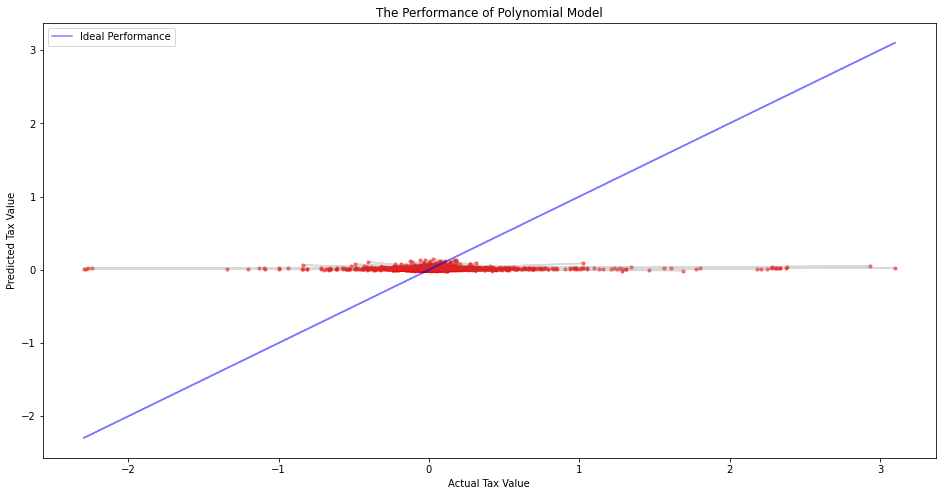

(0.16840361946624535, -0.0002709630126385143)

In [61]:
model.test_poly_lm(train_df, validate_df, test_df, y_train, y_validate, y_test, 2)